In [1]:
from score import report, featurize, test

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
import numpy as np
import pandas as pd
import mordred.AtomCount

# Team Electron
We have decided to include our comments on this notebook as sort of a "storytelling" presentation. Feel free to read our comments as you go!

## Background

This section begins with some of the analysis I found from homework three. First of all, by simply trial and error of many different models (NO FREE LUNCH), I found that the validation error was able to be generalized to 0.6 for the Decision Tree Regressor model. This does not mean we will choose this model in our final submission, but we will begin testing there and looking at similar alternatives.

One of the observations I noted was that the difference between the validation and training errors were not yet converging. That is, the difference was still consistently decreasing even at 100% of the dataset. At the same time, there were no noticeable jitters/extra noise around either the training or the validation datasets, which indicates that the model has the potential to be even more accurate.

The primary limiting factor then (ignoring parameter optimization) is the amount of data. I would hypothesize that with more data, we could reach convergence with this model. Luckily for us, Prof. Tristan gave us multiple datasets to work with. Thus, step one will be preparing our data by combining our datasets. This way, we can take advantage of as much data as possible. Analytically, this only has benefits (will do no harm) as determined in the Hoeffding Inequality.

Let's get started! :)
-RJ

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

# Copy over some useful functions from HW 3
def get_pipeline(models, degree):
    model_tups = [('model-0', PolynomialFeatures(degree))]
    for i in range(len(models)):
        model_tups.append(('model-'+str(i+1), models[i]))
    return Pipeline(model_tups)



## Step 1. Data Preparation

In [4]:
import pandas as pd
import os

# Combine Datasets
def generate_combined_dataset(dir_path, fnames, out_name="", debug=False):
    combined = None
    for f in fnames:
        df = pd.read_csv(dir_path + f)
        if combined is None:
            combined = df.copy()
        else:
            ## Here we do not check for duplicates as Professor Tristan in class informed me that there should not be any duplicate data between the sets
            combined = pd.concat([combined, df])
        if debug:
            print("Added " + str(f) + " with dim", df.shape)
    if debug:
        print("Our combined dataset has", combined.shape[0], "rows with", combined.shape[1], "features.")
    
    if out_name != "":
        if out_name.endswith(".csv"):
            if os.path.exists(out_name):
                print("Combined file already exists at specified output path... rename or replace it first.")
            else:
                combined.to_csv(out_name, index=False)
        else:
            print("ERROR: Output filename must end in .csv")
    return combined
    
# Restriction: "It is forbidden to use any dataset other than A, B, C, D, F, G, H, I"
# So, we make sure we only use these datasets in our data preparation

generate_combined_dataset("../../Data/Solubility/",
                          ["dataset-A.csv", "dataset-B.csv", "dataset-C.csv",
                          "dataset-D.csv", "dataset-F.csv", "dataset-G.csv",
                          "dataset-H.csv", "dataset-I.csv"], "combined.csv")

Combined file already exists at specified output path... rename or replace it first.


,ID,Name,InChI,InChIKey,SMILES,Solubility
0,A-1,"1,2-dichlorobenzene",InChI=1S/C6H4Cl2/c7-5-3-1-2-4-6(5)8/h1-4H,RFFLAFLAYFXFSW-UHFFFAOYSA-N,Clc1ccccc1Cl,-3.177212
1,A-2,"1,2-dichlorobenzene",InChI=1S/C6H4Cl2/c7-5-3-1-2-4-6(5)8/h1-4H,RFFLAFLAYFXFSW-UHFFFAOYSA-N,Clc1ccccc1Cl,-3.180557
2,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
3,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767
4,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078
...,...,...,...,...,...,...
89,I-90,trimethoprim,InChI=1S/C14H18N4O3/c1-19-10-5-8(6-11(20-2)12(...,IEDVJHCEMCRBQM-UHFFFAOYSA-N,c1(nc(c(cn1)Cc1cc(c(c(OC)c1)OC)OC)N)N,-2.950000
90,I-91,trimipramine,InChI=1S/C20H26N2/c1-16(14-21(2)3)15-22-19-10-...,ZSCDBOWYZJWBIY-UHFFFAOYSA-N,CC(CN(C)C)CN1c2ccccc2CCc2ccccc12,-4.790000
91,I-92,tryptamine,InChI=1S/C10H12N2/c11-6-5-8-7-12-10-4-2-1-3-9(...,APJYDQYYACXCRM-UHFFFAOYSA-N,NCCc1c[nH]c2ccccc12,-3.300000
92,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


### Step 2. Feature Engineering

In [5]:
from rdkit import RDLogger

# Explanations of the below features are comments to the right of each feature

features = [
#     mordred.LogS.LogS(),
    mordred.AtomCount.AtomCount('C'), # indicates the number of carbon atoms in a given molecule
    mordred.AtomCount.AtomCount('H'), # indicates the number of hydrogen atoms in a given molecule
    mordred.AtomCount.AtomCount('O'), # indicates the number of oxygen atoms in a given molecule
    mordred.AtomCount.AtomCount('N'), # indicates the number of nitrogen atoms in a given molecule

#      mordred.CPSA.FPSA(5),
#      mordred.CPSA.PPSA(5),
#      mordred.CPSA.FNSA(5),
#      mordred.CPSA.PNSA(5),
#      mordred.CPSA.DPSA(5),   # Would like to see if difference in charged partial surface area will cover the previous 4 features
    
    mordred.CarbonTypes.CarbonTypes(1,2), # for a given molecule, indicates carbon atoms on sp^2 orbital bonded to one other carbon atom
    mordred.HydrogenBond.HBondAcceptor(), # indicates the number of hydrogen bond acceptors for a given molecule
    mordred.HydrogenBond.HBondDonor(),    # indicates the number of hydrogen bond donors for a given molecule
    mordred.TopoPSA.TopoPSA(False),       # indicates the topological polar surface area of a given molecule
    
    # After testing a subset of TopologicalCharge parameter combinations, we've found that the following consistently produces desirable results
    mordred.TopologicalCharge.TopologicalCharge('global', 10), # indicates the 10-ordered global topological charge of a given molecule
    mordred.TopologicalCharge.TopologicalCharge('raw', 3),     # indicates the 3-ordered raw topological charge of a given molecule
    
    mordred.Weight.Weight(True, False), # indicates the exact molecular weight of a given molecule
    mordred.TopologicalIndex.Radius(),  # indicates the topological radius of a given molecule
    mordred.TopologicalIndex.Diameter() # indicates the topological diameter of a given molecule
]

# What better coding practice than ignoring and disabling warnings :)
RDLogger.DisableLog('rdApp.*')

X, y = featurize('combined.csv',features)

100%|██████████| 18504/18504 [01:00<00:00, 307.18it/s]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y)

### Step 3. Visualization

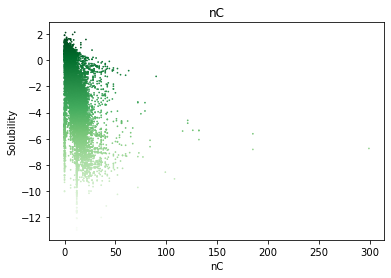

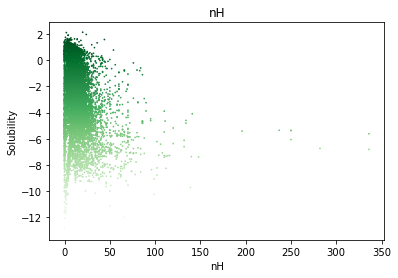

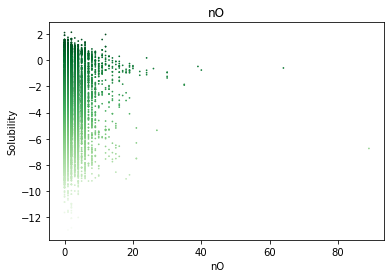

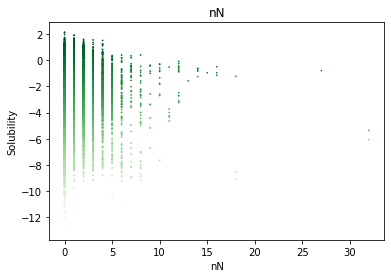

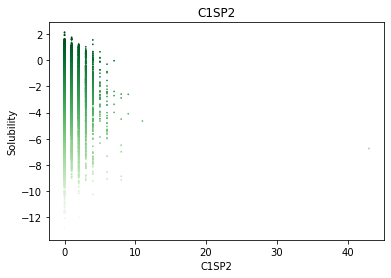

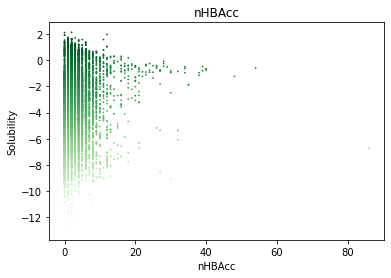

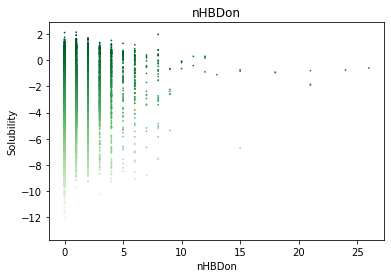

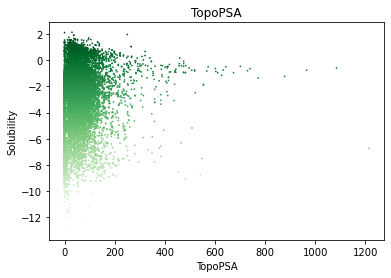

In [75]:
# Here we would plot the features in a 2D plane relative to solubility and visualize how we would best classify the data
def visualize_classify(X_data, y_data, bool_labels, feature_name):  
    ox, oy = X_data[mask], y_data[mask]
    bx, by = X_data[~mask], y_data[~mask]
    plt.title(str(feature_name))
    plt.ylabel("Solubility")
    plt.xlabel(str(feature_name))
    plt.scatter(ox, oy, s=0.5, c='orange')
    plt.scatter(bx, by, s=0.5, c='b')
    plt.show()

def visualize_cmap(X_data, y_data, feature_name):  
    plt.title(str(feature_name))
    plt.ylabel("Solubility")
    plt.xlabel(str(feature_name))
    plt.scatter(X_data, y_data, s=0.5, c=y_data, cmap="Greens")
    plt.show()
 
mask = y_train > y_train.mean()

# We are looking for a way to separate this data with a vertical line for each feature
for i in range(len(features)):
#     visualize_classify(X_train[:,i], y_train, mask, features[i])
    visualize_cmap(X_train[:,i], y_train, features[i])

### Step 3. Model Selection

Let's start by focusing on one model at a time. Once we find the best model, we will use a pipeline to regularize our data and perform other transformations, as necessary.

In [7]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

print("----- DECISION TREE REGRESSOR -----")
models = [DecisionTreeRegressor()]
train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X_train, y_train, param_name="min_samples_split", param_range=[2,3,4])

reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
# pl = Pipeline([('poly', PolynomialFeatures()), ('pca', PCA()), ('ridge', Ridge())])

# # Center training X
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_cent = scaler.transform(X_train)

# # Center testing X
# scaler = StandardScaler()
# scaler.fit(X_test)
# X_test_cent = scaler.transform(X_test)

# mean_absolute_error(y_test, gscv.predict(X_test_cent))

----- DECISION TREE REGRESSOR -----


DecisionTreeRegressor()

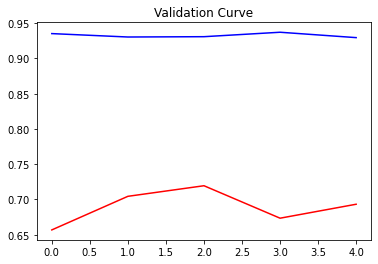

In [8]:
plt.title("Validation Curve")
plt.plot(np.arange(0,train_scores.shape[1]), train_scores.mean(axis=0), c='b')
plt.plot(np.arange(0,valid_scores.shape[1]), valid_scores.mean(axis=0), c='r')

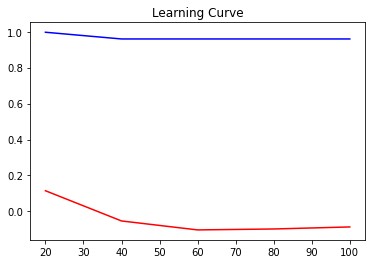

In [9]:
train_sizes, train_scores, valid_scores = learning_curve(DecisionTreeRegressor(), X_train, y_train, train_sizes=[20,40,60,80,100])

plt.title("Learning Curve")
plt.plot(train_sizes, train_scores.mean(axis=0), c='b')
plt.plot(train_sizes, valid_scores.mean(axis=0), c='r')

In [19]:
pl = Pipeline([('scaler', StandardScaler()),('poly', PolynomialFeatures()), ('pca', PCA()), ('dtr', DecisionTreeRegressor())])

## Step 4. Optimization

In [20]:
params = {'poly__degree': [1], 'pca__n_components': [9]}
model = GridSearchCV(pl,params)
model.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('pca', PCA()),
                                       ('dtr', DecisionTreeRegressor())]),
             param_grid={'pca__n_components': [9], 'poly__degree': [1]})

In [12]:
from sklearn.metrics import mean_squared_error as mse

def print_best_model(grid_search_model):
    ranks = grid_search_model.cv_results_["rank_test_score"]
    best_index = np.where(ranks==1)[0][0]
    print("The best model had parameters:", grid_search_model.cv_results_["params"][best_index])
    
print_best_model(model)
# Best
# Poly degree 1
# n_components 9

The best model had parameters: {'pca__n_components': 9, 'poly__degree': 1}


In [13]:
print("Pipeline model\nTrain mae:", mae(model.predict(X_train), y_train))
print("Val mae:", mae(model.predict(X_val), y_val))
# Iter 1 (degree 1, 3 components): val: 0.7572372053158011
# Iter 2 (degree 1, 7 components): val: 0.7112493538174559
# Iter 3 (degree 1, 9 components): val: 0.710107994536287
# Iter 4 (scaled, degree 1, 9 components): val: 0.6995980609456445 Notes: Added StandardScaler in Pipeline
# Iter 5
print()
print("Basic baseline model\nTrain mae:", mae(reg.predict(X_train), y_train), "\nVal mae:", mae(reg.predict(X_val), y_val))

Pipeline model
Train mae: 0.2609743531661233
Val mae: 0.6849469054431669

Basic baseline model
Train mae: 0.2609743531661232 
Val mae: 0.6912914254064665


In [61]:
test(features, model)

100%|██████████| 1291/1291 [00:04<00:00, 322.05it/s]


0.26987346332864937

## Step 5. Future Ideas
#### If we had to do this again from scratch, we would consider exploring alternative ML models. Welcome to Neural Networks!

In [14]:
from sklearn.neural_network import MLPRegressor
nn_model = MLPRegressor(random_state=1, max_iter=500)
nn_model.fit(X_train, y_train)

MLPRegressor(max_iter=500, random_state=1)

In [16]:
def get_mae(model, X_train, y_train, X_val, y_val):
    print("Model errors\nTrain mae:", mae(model.predict(X_train), y_train))
    print("Val mae:", mae(model.predict(X_val), y_val))

get_mae(nn_model, X_train, y_train, X_val, y_val)

Model errors
Train mae: 0.9224738336295768
Val mae: 0.9234386228858634


In [62]:
import torch

In [ ]:
# Could do a CNN, as done in https://www.programmersought.com/article/51599753147/

# From https://github.com/jeah-z/Drug-Solubility-Prediction-Mordred/blob/master/DNN.py
# self.dnn = torch.nn.Sequential(
#             torch.nn.Linear(7,32),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(32,64),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(64,256),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(256,512),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(512,128),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(128,32),
#             torch.nn.Dropout(0.2),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(32,16),
#             torch.nn.ReLU(),
#             torch.nn.Linear(16,5),
#         )

# Many types of NN: Feed forward NN, Recurrent NN, Convolutional NN
# I'm not too versed in all of the specifics of each... or even when to use each type in general
# So, I'm trusting this site (https://towardsdatascience.com/types-of-neural-network-and-what-each-one-does-explained-d9b4c0ed63a1)
# and choosing based off of this. I also used small bits of prior knowledge to influence my decision.

# We would likely go with a DNN, it has proven results and we would be looking for a safe bet here
# The structure of our DNN (with a little help from that online site)
# class DNN(nn.Module):
#     def __init__(self):
#         super(DNN, self).__init__()

#         def convbn(ci,co,ksz,psz,p):
#             return nn.Sequential(
#                 nn.Conv2d(ci,co,ksz),
#                 nn.BatchNorm2d(co),
#                 nn.ReLU(True),
#                 nn.MaxPool2d(psz,stride=psz),
#                 nn.Dropout(p))

#         self.m = nn.Sequential(
#             convbn(1,20,5,3,args.dropout),
#             convbn(20,50,5,2,args.dropout),
#             View(50*2*2),
#             nn.Linear(50*2*2, 500),
#             nn.BatchNorm1d(500),
#             nn.ReLU(True),
#             nn.Dropout(args.dropout),
#             nn.Linear(500,10))

#     def forward(self, x):
#         return self.m(x)


In [ ]:
report(teamname='Electron')